U = 1.50V
I = 0.93A

U = 2.00V
I = 0.97A

U = 2.50V
I = 0.95A

U = 3.00V
I = 0.95A

U = 4.00V
I = 1.00A

Odtud a dál, I kolísá mezi 1.06 - 1.09 a 1.12 - 1.16

U = 5.00V
I = 1.08A

U = 6.00V
I = 1.14A

U = 7.00V
I = 1.10A

U = 8.00V
I = 1.12A



In [99]:
import math
# code modified to change negative values to positive ones
def lmap(f,x):
    return list(map(f,x))

def process_raw_decay_data(voltage, startTime = -1, threshold = 0.7, floating_avg = True):
    peaks = []

    # startTime == -1 => auto cutoff
    auto_cutoff = False
    if(startTime == -1):
        auto_cutoff = True
        startTime = 0

    with open(f"./inputs/{voltage}V.csv") as inp:
        lines = inp.read().split("\n")

        startInd = 1
        while (float(lines[startInd].split(",")[0]) < startTime): startInd += 1
        
        hitPeak = False
        startPeak = 0
        endPeak = 0
        for i in range(startInd, len(lines)-1):
            row = lines[i].split(",")

            if (abs(float(row[1])) >= threshold and not hitPeak):
                hitPeak = True
                startPeak = float(row[0])


            if (abs(float(row[1])) < threshold and hitPeak):
                hitPeak = False
                endPeak = float(row[0])

                peaks.append((endPeak+startPeak)/2)                

    results = {}
    interval = 1
    step = 0.1
    curTime = startTime
    x = 0
    while x < len(peaks):
        if (peaks[x] > curTime+interval):
            curTime += step
            x = 0
        elif (peaks[x] > curTime and peaks[x] < curTime+interval):
            if (not curTime in results): results[curTime] = 1
            else: results[curTime] += 1
            
        x += 1

    cutoff_val = math.inf
    if(auto_cutoff):
        cutoff_val = 0

    if(floating_avg):   
        with open(f"./outputs/{voltage}V_PROCESSED_FLOATING_AVERAGE.csv", 'w') as res:
            res.write("t, peaks/s, omega \n")
            for x in range(4, len(results.keys())):
                flAverage = 0
                for y in range(5):
                    flAverage += results[list(results.keys())[x-y]]
                flAverage = flAverage/5

                if(auto_cutoff):
                    if(flAverage > cutoff_val):
                        cutoff_val = flAverage

                if(flAverage < cutoff_val):
                    res.write(str(round(list(results.keys())[x-y], 1)) + "," + str(flAverage) + "," + str(flAverage*2*math.pi/3) + "\n")

        return f"./outputs/{voltage}V_PROCESSED_FLOATING_AVERAGE.csv"
    else:
        with open(f"./outputs/{voltage}V_PROCESSED.csv", 'w') as res:
            res.write("t, peaks/s \n")
            for key in results.keys():
                res.write(str(round(key, 1)) + "," + str(results[key]) + "\n")
        
        return f"./outputs/{voltage}V_PROCESSED.csv"


In [100]:
processed_paths = []
for i in ["1-5", "2", "2-5", "3", "4", "5", "6", "7", "8"]:
    out_path = process_raw_decay_data(i, -1, 0.7, True)
    processed_paths.append(out_path)

# Fitting for $\alpha$, $\gamma$, $c_1$

$$
\omega(t) = - \sqrt{\frac{\alpha}{\gamma}} \tan{(\sqrt{\alpha\gamma}(t+c_1))}
$$

[3.0859505150485997, 5.238395106675421, 7.267121070825904, 9.457357440139969, 13.505856417432712, 17.503159070000308, 21.339710098475, 26.091684395096944, 30.52739528033711]
[1.5, 2, 2.5, 3, 4, 5, 6, 7, 8]
4.172830546546538x + -3.1915291023647714


Text(2, 30, 'fit = 4.1728x + -3.1915')

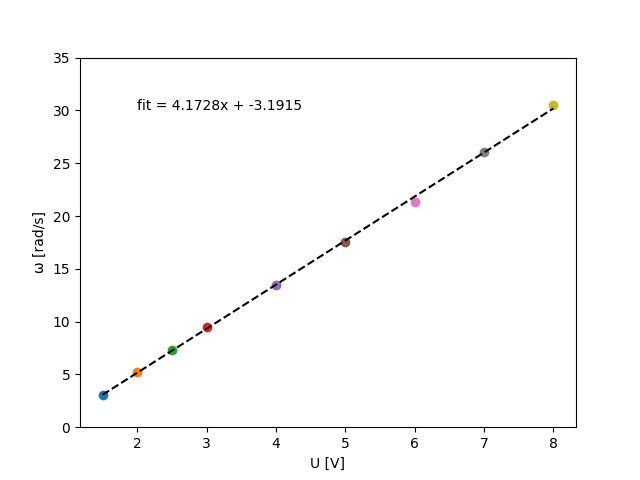

In [101]:
import scipy.optimize as opt
import numpy as np
import matplotlib.pyplot as plt

%matplotlib widget

alphas = []
gammas = []
cs = []
omega_0s = []
R_squares = []

plt.figure()
plt.ylim(0, 35)
voltages = [1.5, 2, 2.5, 3, 4, 5, 6, 7, 8]
rpms = []
for i in range(len(processed_paths)):
    path = processed_paths[i]
    with open(path, "r") as read:
        data = read.readlines()[1:]
        data = lmap(lambda row: row.rstrip().split(","), data)

        xdata = lmap(lambda row: float(row[0]), data)
        ydata = sum(lmap(lambda row: float(row[2]), data))/len(data)
        rpms.append(ydata)

        plt.scatter(voltages[i], ydata)
        plt.xlabel("U [V]")
        plt.ylabel("ω [rad/s]")

        # plt.xticks(np.arange(min(xdata), max(xdata) + 1, 20.0))
        # plt.yticks(np.arange(min(ydata), max(ydata) + 1, 10.0))

        # plt.title(f"Spinner {i+1} decay rate")
        # plt.text(max(xdata) * 0.8, max(ydata) * 0.7, f"α={alpha:.3f}\nγ={gamma:.6f}\nc1={c:.1f}\n\nR^2={r_squared:.5f}")
        

        # plt.legend()
print(rpms)
print(voltages)
m, n = np.polyfit(voltages, rpms, 1)
print(f"{m}x + {n}")
a = min(voltages)
b = max(voltages)
plt.plot([a, b], [m*a + n, m*b + n], "k--")
plt.text(2, 30, f"fit = {round(m, 4)}x + {round(n, 4)}")
# opt.curve_fit(lambda x, y: [y for i in x], voltages, ydata)
